In [1]:
# Imports
import sys

from utils.paths import MAIN_DIRECTORY, REL_DATA_DIR

if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

%matplotlib ipympl
%matplotlib inline


import os
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from matplotlib.patches import Rectangle
from pandas.plotting import autocorrelation_plot
from plotly.subplots import make_subplots
from scipy.fft import fft, fftfreq, rfft, rfftfreq

from utils.load import add_noise, load_data
from utils.params import set_param

In [2]:
# Get Data Function


def get_data(exp):

    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = prop_cycle.by_key()["color"]

    fontsize = 12
    plt.rcParams.update({"font.size": fontsize})

    np.random.seed(42)

    tic_begin = time.time()

    dirs = {"main": MAIN_DIRECTORY}

    ##%% Set case study
    plt.close("all")

    params = set_param(exp)

    # dirs["data"] = dirs["main"] + "/" + params["dir_data"]
    dirs["data"] = dirs["main"] + "/" + REL_DATA_DIR + "/" + params["dir_data"]

    #% Load data
    print("")
    print(f"Loading data from {exp}: ", end="")
    X, Y, t, dt, vl = load_data(exp, dirs, params)
    print("done")

    Anoise = 0.0
    X = add_noise(X, Anoise, rand_seed=42)

    return X, Y, t, dt, vl, params["obs_label"], params["time_label"]

In [3]:
# Saves data for all experiments into dictionary


exp = [
    "b726",
    "b698",
    "i417",
    "p4679",
    "p4581",
    "sim_b726",
    "sim_b698",
    "sim_i417",
    "cascadia",
]

# Initialize dictionaries for each variable
X_dict = {}
y_dict = {}
t_dict = {}
dt_dict = {}
vl_dict = {}
y_label_dict = {}
x_label_dict = {}

for exp_value in exp:
    X, Y, t, dt, vl, y_label, x_label = get_data(exp_value)

    # Store each variable in its respective dictionary
    X_dict[exp_value] = X
    y_dict[exp_value] = Y
    t_dict[exp_value] = t
    dt_dict[exp_value] = dt
    vl_dict[exp_value] = vl
    y_label_dict[exp_value] = y_label
    x_label_dict[exp_value] = x_label

# Checking the keys to confirm that the data is stored correctly
# X_dict.keys(), y_dict.keys(), t_dict.keys(), dt_dict.keys(), vl_dict.keys(), y_label_dict.keys(), x_label_dict.keys()


Loading data from b726: done

Loading data from b698: done

Loading data from i417: done

Loading data from p4679: done

Loading data from p4581: done

Loading data from sim_b726: done

Loading data from sim_b698: done

Loading data from sim_i417: done

Loading data from cascadia: done


In [ ]:
# Creates interactive plot to view experiment data

import ipywidgets as widgets
from IPython.display import display

# Create the dropdown widget
exp_dropdown = widgets.Dropdown(
    options=exp, description="Select exp:", value=exp[0]
)

# Define the plot function


def plot_X(exp_value):
    X = X_dict[exp_value]

    plt.figure(
        figsize=(12, 6)
    )  # Adjust the figure size to make it wide and short

    # Original plot
    plt.subplot(
        2, 1, 1
    )  # Add a subplot with 2 rows and 1 column, and select the first subplot
    plt.plot(t_dict[exp_value], X, ".k")
    plt.title(f"Experiment: {exp_value}")
    plt.xlabel(x_label_dict[exp_value])
    plt.ylabel(y_label_dict[exp_value])

    num_points = int(
        len(X) * 0.2
    )  # Calculate the number of data points to display in zoomed plot

    # Draw a red box on original plot
    zoom_start = t_dict[exp_value][0]
    zoom_end = t_dict[exp_value][num_points - 1]
    zoom_width = zoom_end - zoom_start
    zoom_height = np.max(X) - np.min(X)
    rect = Rectangle(
        (zoom_start, np.min(X)),
        zoom_width,
        zoom_height,
        edgecolor="red",
        facecolor="none",
    )
    plt.gca().add_patch(rect)

    # Zoomed plot
    plt.subplot(
        2, 1, 2
    )  # Add a subplot with 2 rows and 1 column, and select the second subplot
    plt.plot(t_dict[exp_value][:num_points], X[:num_points], ".k")
    plt.title("Zoomed Plot")
    plt.xlabel(x_label_dict[exp_value])
    plt.ylabel(y_label_dict[exp_value])
    plt.ticklabel_format(useOffset=False)  # Display axis labels in full
    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()


# Register the plot function as the dropdown's event handler
widgets.interact(plot_X, exp_value=exp_dropdown)

In [5]:
# Building a Class called FFT to calculate Fourier transforms and Power Spectrum.


class FFT:
    """
    Apply the Discrete Fourier Transform (DFT) on the signal using the Fast Fourier
    Transform (FFT) from the scipy package.

    Example:
      fourier = Fourier(signal, sampling_rate=2000.0)
    """

    def __init__(self, signal, sampling_rate):
        """
        Initialize the Fourier class.

        Args:
            signal (np.ndarray): The samples of the signal
            sampling_rate (float): The sampling per second of the signal

        Additional parameters,which are required to generate Fourier calculations, are
        calculated and defined to be initialized here too:
            time_step (float): 1.0/sampling_rate
            time_axis (np.ndarray): Generate the time axis from the duration and
                                  the time_step of the signal. The time axis is
                                  for better representation of the signal.
            duration (float): The duration of the signal in seconds.
            frequencies (numpy.ndarray): The frequency axis to generate the spectrum.
            fourier (numpy.ndarray): The DFT using rfft from the scipy package.
        """
        self.signal = signal
        self.sampling_rate = sampling_rate
        self.time_step = 1.0 / self.sampling_rate
        self.duration = len(self.signal) / self.sampling_rate
        self.time_axis = np.arange(0, self.duration, self.time_step)
        self.frequencies = rfftfreq(len(self.signal), d=self.time_step)
        self.fourier = rfft(self.signal)
        self.power_spectrum = np.abs(self.fourier) ** 2 / len(self.signal)

    # Generate the actual amplitudes of the spectrum
    def amplitude(self):
        """
        Method of Fourier

        Returns:
            numpy.ndarray of the actual amplitudes of the sinusoids.
        """
        return 2 * np.abs(self.fourier) / len(self.signal)

    # Generate the phase information from the output of rfft
    def phase(self, degree=False):
        """
        Method of Fourier

        Args:
            degree: To choose the type of phase representation (Radian, Degree).
                    By default, it's in radian.

        Returns:
            numpy.ndarray of the phase information of the Fourier output.
        """
        return np.angle(self.fourier, deg=degree)

    # Plot the spectrum
    def plot_spectrum(self, interactive=False):
        """
        Plot the Spectrum (Frequency Domain) of the signal either using the matplotlib
        package, or plot it interactive using the plotly package.

        Args:
            interactive: To choose if you want the plot interactive (True), or not
            (False). The default is the spectrum non-interactive.

        Retruns:
            A plot of the spectrum.
        """
        # When the argument interactive is set to True:
        if interactive:
            self.trace = go.Line(x=self.frequencies, y=self.amplitude())
            self.data = [self.trace]
            self.layout = go.Layout(
                title=dict(
                    text="Spectrum",
                    x=0.5,
                    xanchor="center",
                    yanchor="top",
                    font=dict(size=25, family="Arial, bold"),
                ),
                xaxis=dict(title="Frequency[Hz]"),
                yaxis=dict(title="Amplitude"),
            )
            self.fig = go.Figure(data=self.data, layout=self.layout)
            return self.fig.show()
        # When the argument interactive is set to False:
        else:
            plt.figure(figsize=(10, 6))
            plt.plot(self.frequencies, self.amplitude())
            plt.title("Spectrum")
            plt.ylabel("Amplitude")
            plt.xlabel("Frequency[Hz]")

    # Plot the Signal and the Spectrum interactively
    def plot_time_frequency(
        self,
        t_ylabel="Amplitude",
        f_ylabel="Amplitude",
        t_title="Signal (Time Domain)",
        f_title="Spectrum (Frequency Domain)",
    ):
        """
        Plot the Signal in Time Domain and Frequency Domain using plotly.

        Args:
            t_ylabel (String): Label of the y-axis in Time-Domain
            f_ylabel (String): Label of the y-axis in Frequency-Domain
            t_title (String): Title of the Time-Domain plot
            f_title (String): Title of the Frequency-Domain plot

        Returns:
            Two figures: the first is the time-domain, and the second is the
                         frequency-domain.
        """
        # The Signal (Time-Domain)
        self.time_trace = go.Line(x=self.time_axis, y=self.signal)
        self.time_domain = [self.time_trace]
        self.layout = go.Layout(
            title=dict(
                text=t_title,
                x=0.5,
                xanchor="center",
                yanchor="top",
                font=dict(size=25, family="Arial, bold"),
            ),
            xaxis=dict(title="Time[sec]"),
            yaxis=dict(title=t_ylabel),
            width=1000,
            height=400,
        )
        fig = go.Figure(data=self.time_domain, layout=self.layout)
        fig.show()
        # The Spectrum (Frequency-Domain)
        self.freq_trace = go.Line(x=self.frequencies, y=self.amplitude())
        self.frequency_domain = [self.freq_trace]
        self.layout = go.Layout(
            title=dict(
                text=f_title,
                x=0.5,
                xanchor="center",
                yanchor="top",
                font=dict(size=25, family="Arial, bold"),
            ),
            xaxis=dict(title="Frequency[Hz]"),
            yaxis=dict(title=f_ylabel),
            width=1000,
            height=400,
        )
        fig = go.Figure(data=self.frequency_domain, layout=self.layout)
        fig.show()

## Figure 2 in the report:

In [28]:
exp_ex_cascadia = "cascadia"
data = FFT(X_dict[exp_value].reshape(-1), 1 / dt_dict[exp_value])
data.time_axis

array([0.00000000e+00, 2.73785079e-03, 5.47570157e-03, ...,
       1.06228611e+01, 1.06255989e+01, 1.06283368e+01])

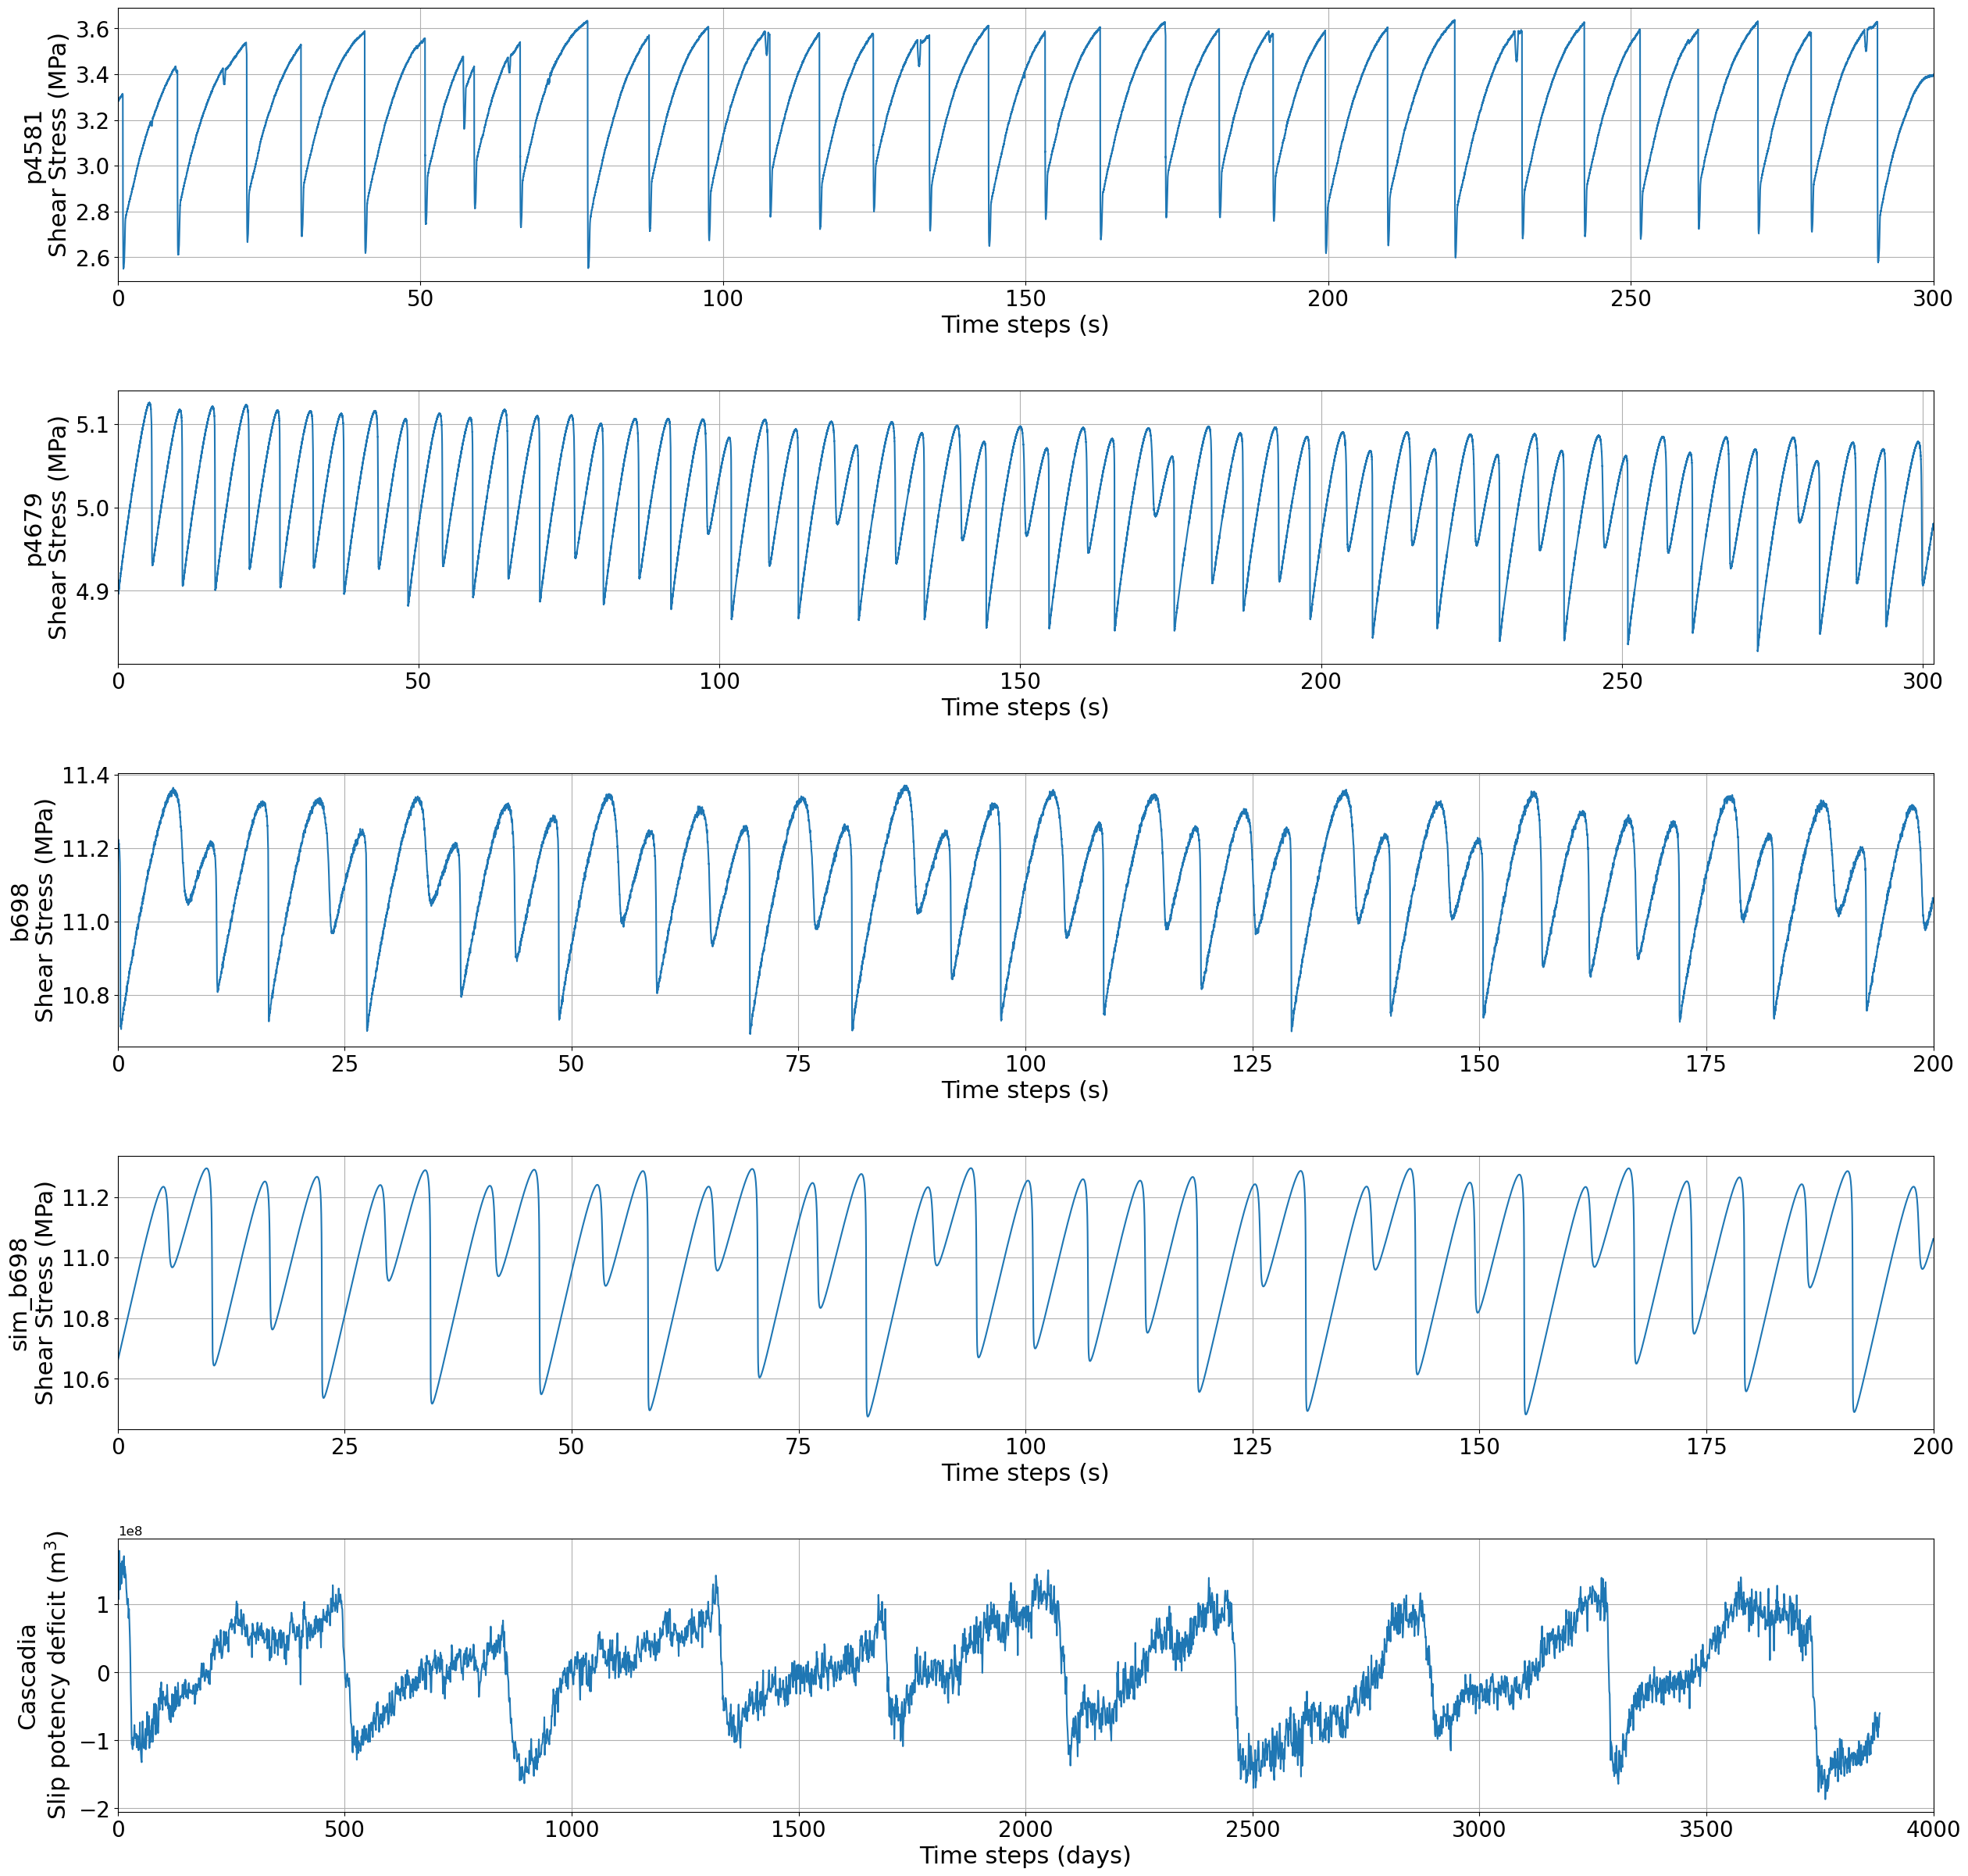

In [38]:
import matplotlib.ticker as tck
from matplotlib.ticker import MaxNLocator

exp_ex_cascadia = ["p4581", "p4679", "b698", "sim_b698", "cascadia"]


# Create a figure with three subplots
fig, axs = plt.subplots(
    len(exp_ex_cascadia),
    1,
    figsize=(30, 6 * len(exp_ex_cascadia)),
)

for i, exp_value in enumerate(exp_ex_cascadia):

    data = FFT(X_dict[exp_value].reshape(-1), 1 / dt_dict[exp_value])

    quantity = ""
    if exp_value[0] in "pbs":
        axs[i].plot(data.time_axis, data.signal)  # , color="black")
        axs[i].set_ylabel(exp_value + "\nShear Stress (MPa)", fontsize=22)
        axs[i].set_xlabel("Time steps (s)", fontsize=22)
        axs[i].set_xlim(0, len(data.signal) * data.time_step)

    elif exp_value[0] in "c":
        axs[i].plot(np.arange(0, 3883, 1), data.signal)  # , color="black")
        axs[i].set_ylabel(
            "C" + exp_value[1:] + "\nSlip potency deficit (m$^3$)", fontsize=22
        )
        axs[i].set_xlabel("Time steps (days)", fontsize=22)
        axs[i].set_xlim(0, 4000)

    axs[i].grid(True)  # Add gridlines
    axs[i].tick_params(axis="both", which="major", labelsize=20)


plt.subplots_adjust(wspace=0.2, hspace=0.4)

# Show the figure
plt.show()

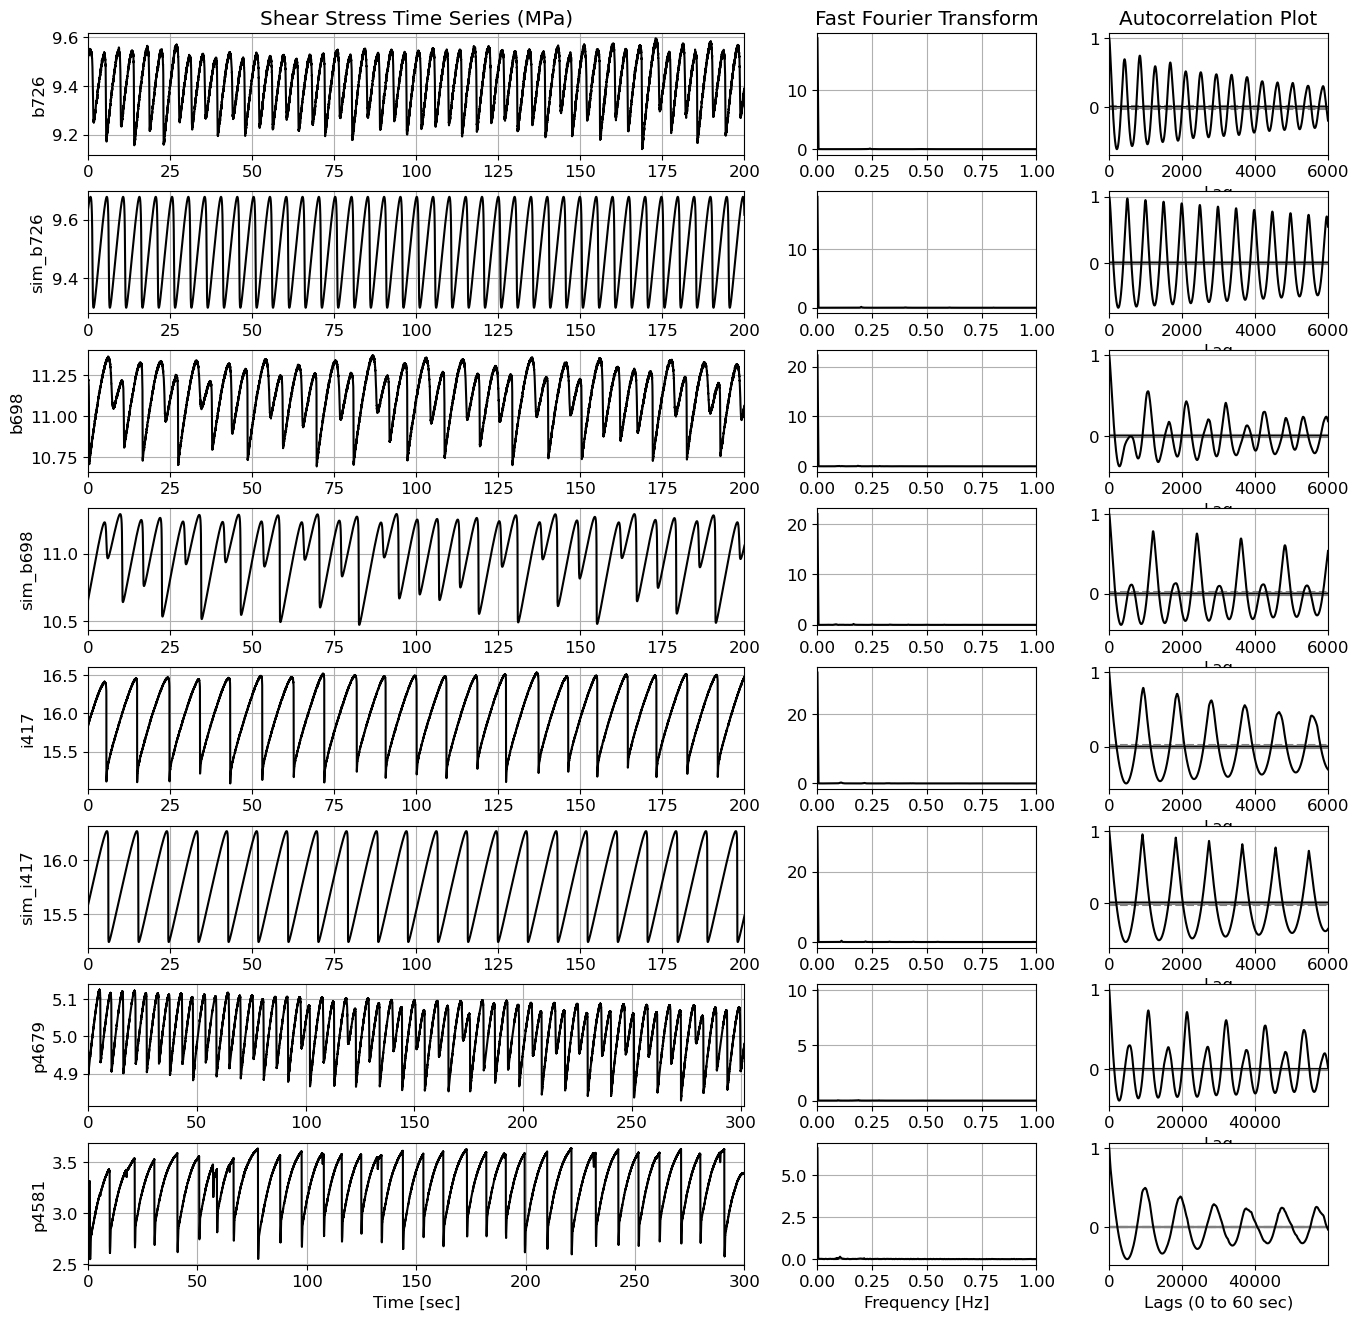

In [7]:
exp_ex_cascadia = [
    "b726",
    "sim_b726",
    "b698",
    "sim_b698",
    "i417",
    "sim_i417",
    "p4679",
    "p4581",
]

# Create a figure with three subplots
fig, axs = plt.subplots(
    len(exp_ex_cascadia),
    3,
    figsize=(16, 2 * len(exp_ex_cascadia)),
    gridspec_kw={"width_ratios": [0.6, 0.2, 0.2]},
)

for i, exp_value in enumerate(exp_ex_cascadia):
    data = FFT(X_dict[exp_value].reshape(-1), 1 / dt_dict[exp_value])

    # The Signal (Time-Domain)
    axs[i, 0].plot(data.time_axis, data.signal, color="black")
    if i == 0:
        axs[i, 0].set_title("Shear Stress Time Series (MPa)")
    if i == len(exp_ex_cascadia) - 1:
        axs[i, 0].set_xlabel("Time [sec]")
    axs[i, 0].set_ylabel(exp_value)
    axs[i, 0].grid(True)  # Add gridlines
    axs[i, 0].set_xlim(0, len(data.signal) * data.time_step)

    # The Spectrum (Frequency-Domain)
    axs[i, 1].plot(data.frequencies, data.amplitude(), color="black")
    if i == 0:
        axs[i, 1].set_title("Fast Fourier Transform")
    if i == len(exp_ex_cascadia) - 1:
        axs[i, 1].set_xlabel("Frequency [Hz]")
    axs[i, 1].set_xlim(0, 1)
    axs[i, 1].grid(True)  # Add gridlines

    # Autocorrelation plot
    autocorrelation_plot(X_dict[exp_value], ax=axs[i, 2], color="black")
    time_step = t_dict[exp_value][1] - t_dict[exp_value][0]
    if i == 0:
        axs[i, 2].set_title("Autocorrelation Plot")
    if i == len(exp_ex_cascadia) - 1:
        axs[i, 2].set_xlabel("Lags (0 to 60 sec)")
    axs[i, 2].set_ylabel("")  # Set y-axis label to empty
    axs[i, 2].grid(True)  # Add gridlines
    axs[i, 2].set_xlim(0, 60 / time_step)

plt.subplots_adjust(wspace=0.2, hspace=0.3)

# Show the figure
plt.show()

In [ ]:
exp_value = "cascadia"
autocorrelation_plot(X_dict[exp_value], color="black")
plt.title(f"Autocorrelation Plot - {exp_value}")
plt.xlabel("Lags (Days)")
plt.ylabel("Autocorrelation")
plt.show()

In [ ]:
for i in exp:
    print(
        f"Experiment {i}: X length is {len(X_dict[i])}, y length is {len(y_dict[i])}"
    )